<a href="https://colab.research.google.com/github/danort92/Face-Detection/blob/main/Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install imgaug

In [ ]:
import os
from PIL import Image
import glob
import collections

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmenters import Fliplr, Flipud, Affine
from itertools import chain
from skimage import data, color, feature
import skimage.data
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV

In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 

In [ ]:
#import image dataset
path="C:\\Users\\danil\\OneDrive\\Data Science\\ProfessionAI\\10_Machine_Learning_CV"
os.chdir(path)
pos_path = glob.glob (path + "\\train_positive_set\\Caltech_CropFaces" + "\*.jpg")
neg_path = glob.glob (path + "\\train_negative_set" + "\*.jpg")

In [ ]:
#function to create an array of grey images with predefined size of 36x36
#to use to build the negative and positive train dataset
def create_img_array(path):
    img_array=[]
    for file in path:
        image = cv2.imread (file)
        image = cv2.resize(image, dsize=(36,36))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_array.append(image)
    return img_array

pos_set=create_img_array(pos_path)
neg_set=create_img_array(neg_path)

In [ ]:
print('Positive images set shape:', np.array(pos_set).shape)
print('Negative images set shape:', np.array(neg_set).shape)

Positive images set shape: (6713, 36, 36)
Negative images set shape: (274, 36, 36)


In [ ]:
#function to show a subset of the images array previously created
def show_img_subplot(img_set):
    fig, ax = plt.subplots(4, 8, figsize=(10, 4))
    n_images=np.array(img_set).shape[0]
    for i, axi in enumerate(ax.flat):
        k=np.random.choice(n_images,1)[0]
        axi.imshow(img_set[k], cmap='gray')
        axi.axis('off')    

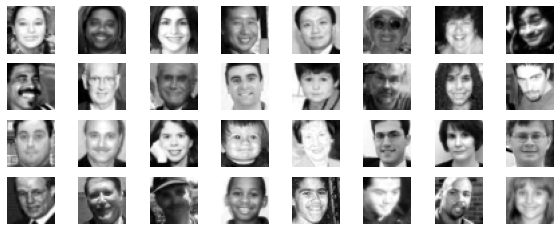

In [ ]:
show_img_subplot(pos_set)

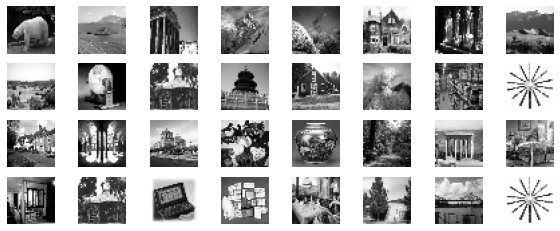

In [ ]:
show_img_subplot(neg_set)

## DATA AUGMENTATION

In [ ]:
#original script found on https://imgaug.readthedocs.io/ and slightly modified in order to perform data augmentation
#it mirrors, flip uspide down and tilt random images adding them to the dataset

def img_augmentation(img_set,k=1):
    """
    img_set - np.array with shape (n,w,h), where n is the number of images and w,h are width and height
    augment_function  - Fliplr (horiziontal flip)
                      - Flipud (vertical flip)
                      - Affine (shear between -30 and +30)
    k - constant, precentage of images randomly chosen from the original set of images
    """

    n_images=np.array(img_set).shape[0]
    aug_set=[]
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    for i in range(1,int(k*n_images)):
        r=np.random.choice(n_images,1)[0]
        
        hflip= iaa.Fliplr(p=0.6)
        aug_hor_image= hflip.augment_image(img_set[r])
        aug_set.append(aug_hor_image)
        
        vflip= iaa.Flipud(p=0.2)
        aug_ver_image= vflip.augment_image(img_set[r])
        aug_set.append(aug_ver_image)
        
        aff = sometimes(iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-25, 25),
                    shear=(-30, 30),
                    order=[0, 1],
                    cval=(0, 255),
                    mode=ia.ALL))
        aug_aff_image= aff.augment_image(img_set[r])
        aug_set.append(aug_aff_image)
        
        crop=sometimes(iaa.Crop(percent=(0, 0.1)))
        aug_crop_image= crop.augment_image(img_set[r])
        aug_set.append(aug_crop_image)
        
        #i+=1

    return aug_set

In [ ]:
#original script found on https://imgaug.readthedocs.io/ and slightly modified in order to perform data augmentation
#it mirrors, flip uspide down and tilt random images adding them to the dataset

def img_pos_augmentation(img_set,k=1):
    """
    img_set - np.array with shape (n,w,h), where n is the number of images and w,h are width and height
    augment_function  - Fliplr (horiziontal flip)
                      - Flipud (vertical flip)
                      - Affine (shear between -30 and +30)
    k - constant, precentage of images randomly chosen from the original set of images
    """

    n_images=np.array(img_set).shape[0]
    aug_set=[]
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    for i in range(1,int(k*n_images)):
        r=np.random.choice(n_images,1)[0]
        
        hflip= iaa.Fliplr(p=0.6)
        aug_hor_image= hflip.augment_image(img_set[r])
        aug_set.append(aug_hor_image)
        
        

    return aug_set

In [ ]:
#creation of augemnted positive set
#aug_pos_set=img_pos_augmentation(pos_set,k=1)
aug_pos_set=pos_set
np.array(aug_pos_set).shape

(6713, 36, 36)

In [ ]:
#creation of augmented negative set
aug_neg_set=img_augmentation(neg_set,k=10)
np.array(aug_neg_set).shape

(10956, 36, 36)

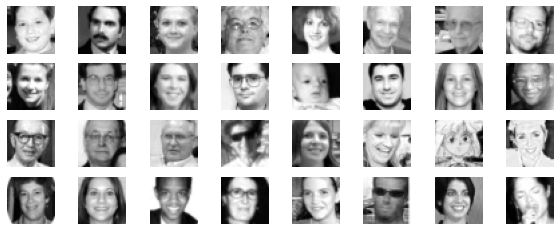

In [ ]:
show_img_subplot(aug_pos_set)

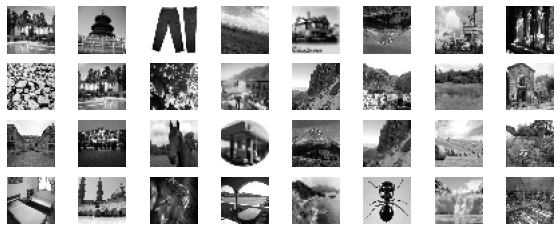

In [ ]:
show_img_subplot(aug_neg_set)

## SVM MODEL

In [ ]:
#script found on https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV
#it iterates to find the best estimators for the binary classification model GridSearchCV
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.97, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.97

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [ ]:
#creation of train features and labels
#for face detection problems HOG (Histogram Of Gradients) is a good detection method because 
# object shape is characterized using the local intensity gradient distribution and edge direction
X_train = np.array([feature.hog(im, pixels_per_cell=(6,6))
                    for im in chain(aug_pos_set,
                                    aug_neg_set)])
y_train = np.zeros(X_train.shape[0])
y_train[:np.shape(aug_pos_set)[0]] = 1

In [ ]:
X_train.shape,y_train.shape

((17669, 1296), (17669,))

In [ ]:
#use of Support Vector Classification model
scoring = ['precision','recall']
grid = GridSearchCV(LinearSVC(random_state=1), 
                    {"C": [0.001,0.0025,0.005,0.01,0.025,0.05]},
                    scoring=scoring,
                    verbose=2,
                   refit=refit_strategy)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ...........................................C=0.0025; total time=   0.3s
[CV] END ...........................................C=0.0025; total time=   0.3s
[CV] END ...........................................C=0.0025; total time=   0.3s
[CV] END ...........................................C=0.0025; total time=   0.3s
[CV] END ...........................................C=0.0025; total time=   0.3s
[CV] END ............................................C=0.005; total time=   0.3s
[CV] END ........................................

GridSearchCV(estimator=LinearSVC(random_state=1),
             param_grid={'C': [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]},
             refit=<function refit_strategy at 0x00000281425E9700>,
             scoring=['precision', 'recall'], verbose=2)

In [ ]:
#use of best estimators to train the model
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=0.025, random_state=1)

## TESTING

In [ ]:
import numpy as np

def non_max_supr_bbox(bboxes, confidences, img_size, verbose=False):
    """
    FUNC: high confidence detections suppress all overlapping detections
        (including detections at other scales). Detections can partially
        overlap, but the center of one detection can not be within another
        detection.
    ARG:
        - bboxes: (N,4) ndarray; N is the number of non-overlapping detections,
                  and each row is [x_min, y_min, x_max, y_max].
        - confidences: (N,1) ndarray; Confidence of each detection after final
                  cascade node.
        - img_size: (2,) list; [y,x] of the image.
    RET:
        - is_valid_bbox: (N,1) bool ndarray; indicating valid bounding boxes.
    """

    # Truncate bounding boxes to image dimensions
    x_out_of_bounds = bboxes[:, 2] > img_size[1]  # xmax greater than x dimension
    y_out_of_bounds = bboxes[:, 3] > img_size[0]  # ymax greater than y dimension

    bboxes[x_out_of_bounds, 2] = img_size[1]
    bboxes[y_out_of_bounds, 3] = img_size[0]

    num_detections, _ = confidences.shape

    # higher confidence detections get priority
    ind = np.argsort(-confidences, axis=0).ravel()
    bboxes = bboxes[ind, :]

    # indicator for whether each bbox will be accepted or suppressed
    is_valid_bbox = np.zeros((num_detections, 1), dtype=np.bool)
    for i in range(num_detections):
        cur_bb = bboxes[i, :]
        cur_bb_is_valid = True

        for j in np.where(is_valid_bbox)[0]:
            prev_bb = bboxes[j, :]
            bi = [max(cur_bb[0], prev_bb[0]),
                  max(cur_bb[1], prev_bb[1]),
                  min(cur_bb[2], prev_bb[2]),
                  min(cur_bb[3], prev_bb[3])]
            iw = bi[2] - bi[0] + 1
            ih = bi[3] - bi[1] + 1
            if iw > 0 and ih > 0:
                # compute overlap as area of intersection / area of union
                ua = (cur_bb[2] - cur_bb[0] + 1) * (cur_bb[3] - cur_bb[1] + 1) + \
                     (prev_bb[2] - prev_bb[0] + 1) * (prev_bb[3] - prev_bb[1] + 1) - \
                     iw * ih
                ov = iw * ih / ua
                # if the less confident detection overlaps too much with the previous detection
                if ov > 0.2:
                    cur_bb_is_valid = False

                center_coord = [(cur_bb[0] + cur_bb[2]) / 2, (cur_bb[1] + cur_bb[3]) / 2]
                if (center_coord[0] > prev_bb[0]) and (center_coord[0] < prev_bb[2]) and \
                        (center_coord[1] > prev_bb[1]) and (center_coord[1] < prev_bb[3]):
                    cur_bb_is_valid = False

                if verbose:
                    print('detection {}, bbox: [{},{},{},{}], {} overlap with {} [{},{},{},{}]'.format( \
                        i, cur_bb[0], cur_bb[1], cur_bb[2], cur_bb[3], ov, j, prev_bb[0], prev_bb[1], \
                        prev_bb[2], prev_bb[3]))

        is_valid_bbox[i] = cur_bb_is_valid

    # This statement returns the logical array 'is_valid_bbox' back to the order
    # of the input bboxes and confidences
    reverse_map = np.zeros((num_detections,), dtype=np.int)
    reverse_map[ind] = np.arange(num_detections)
    is_valid_bbox = is_valid_bbox[reverse_map, :]

    return is_valid_bbox

In [ ]:

def sliding_window(test_scn_path, patch_size=aug_pos_set[0].shape, step=3, 
                   p_threshold=1.5, n_threshold=-0.5, downsample=0.8):
    
    test_set=os.listdir(test_scn_path)
    
    #initialize bounding boxes, confidence levels and image names
    bboxes = np.zeros([0, 4])
    confidences = np.zeros([0, 1])
    image_ids = np.zeros([0, 1])
    
    #initialize array for hard negative mining 
    #(to populate with patches with confidence lower than n_threshold)
    hard_neg_set=[]
    
    for k in range(len(test_set)):
        
        #start from a specific image scale and iterate downsampling to find face patterns at different scales
        scale_factor=1
        img = cv2.imread(os.path.join(test_scn_path, test_set[k]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #rescale all images to start sliding window iteration from a specific dimension
        #img = skimage.transform.rescale(img, 4*patch_size[0]/max(img.shape[0],img.shape[1]))
        
        #initialize k_image bounding boxes, confidence levels and image name
        patches_ok=[]
        k_bboxes = np.zeros([0, 4])
        k_confidences = np.zeros([0, 1])
        k_image_ids = np.zeros([0, 1])
        
        #step with overlap (parameter to set up when calling the function, default=0.25)
        W, H = (int(s) for s in patch_size)
        #W_step=step
        #H_step=step
        
        #starting from a higher scale and downsampling until 
        #the minimum value between width and height becomes lower than patch size 
        while min(img.shape[0],img.shape[1])*scale_factor >= patch_size[0]:
        
            #resize img with scale parameter
            img_re=resize(img, (int(img.shape[0]*scale_factor), int(img.shape[1]*scale_factor)))
            
            #slidig window with predefined steps and creation of HOG features
            for i in range(0, img_re.shape[0] - W, step):
                for j in range(0, img_re.shape[1] - H, step):
                     
                    patch = img_re[i:i + W, j:j + H]
                    patch_hog = feature.hog(patch, pixels_per_cell=(6,6))
                
                    #if the confidence is high enough a bounding box is defined, 
                    #otherwise hard negative mining set is populated
                    confidence = model.decision_function(patch_hog.reshape(1, -1))
                    if confidence>=p_threshold:
                        patches_ok.append(patch_hog)
                        x_min = j/scale_factor
                        y_min = i/scale_factor
                        x_max = (j+W)/scale_factor
                        y_max = (i+H)/scale_factor

                        k_bboxes = np.concatenate((k_bboxes, [[x_min, y_min, x_max, y_max]]), 0)
                        k_confidences = np.concatenate((k_confidences, [confidence]), 0)
                        k_image_ids = np.concatenate((k_image_ids, [[test_set[k]]]), 0)

                    elif confidence<n_threshold:
                        hard_neg_set.append(patch)
                        
            scale_factor = scale_factor * downsample
            
        #added to remove bounding boxes overlapping each others, preference to higher confidence
        is_maximum = non_max_supr_bbox(k_bboxes, k_confidences, img.shape)

        k_bboxes = k_bboxes[is_maximum[:, 0], :]
        k_confidences = k_confidences[is_maximum[:, 0], :]
        k_image_ids = k_image_ids[is_maximum[:, 0]]

        bboxes = np.concatenate([bboxes, k_bboxes], 0)
        confidences = np.concatenate([confidences, k_confidences], 0) 
        image_ids = np.concatenate([image_ids, k_image_ids], 0)
        
    print("DONE: run_detector")
    return bboxes, confidences, image_ids, hard_neg_set

In [ ]:
# function that plots images with corresponding bounding boxes
def show_bboxes(test_scn_path,bboxes,image_ids):
    
    patch_size=aug_pos_set[0].shape
    test_set=os.listdir(test_scn_path)
    counter = collections.Counter(image_ids[:,0])
    counter=dict(counter)
    
    answer=""
    img_index=0
    m=0
    while answer.lower()!="no" and img_index<len(counter):
        fig, ax = plt.subplots()
        img = cv2.imread(os.path.join(test_scn_path, test_set[img_index]))
        img = color.rgb2gray(img)
        plt.imshow(img, cmap='gray')
        plt.axis('on')
        n=m+list(counter.values())[img_index]
        for i in range(m,n):
            #if confidences[i]>=0.2*max(confidences):
                ax.add_patch(plt.Rectangle((bboxes[i][0],bboxes[i][1]), 
                                        bboxes[i][2]-bboxes[i][0], bboxes[i][3]-bboxes[i][1], 
                                        edgecolor='red',alpha=0.3, lw=2, facecolor='none'))
        plt.show()
        m=n
        img_index=img_index+1
        answer=input(f"Visualize the {img_index+1}° image? [Digit anything for yes/no]: ") 

In [ ]:
test_scn_path="C:\\Users\\danil\\OneDrive\\Data Science\\ProfessionAI\\10_Machine_Learning_CV\\prova"
bboxes, confidences, image_ids, hard_neg_set=sliding_window(test_scn_path)

DONE: run_detector


In [ ]:
#print of bounding boxes
print(bboxes.shape[0])

29


In [ ]:
# creation of a dictionary to see how many bounding boxes are found for each image
counter = collections.Counter(image_ids[:,0])
counter=dict(counter)
counter

{'33190.jpg': 6,
 'aerosmith-double.jpg': 10,
 'albert.jpg': 1,
 'audrey1.jpg': 4,
 'bttf206.jpg': 7,
 'cfb.jpg': 1}

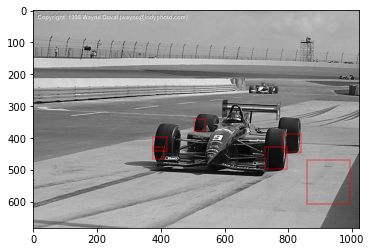

Visualize the 2° image? [Digit anything for yes/no]: 


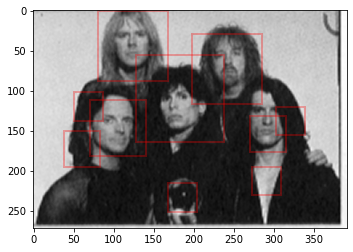

Visualize the 3° image? [Digit anything for yes/no]: 


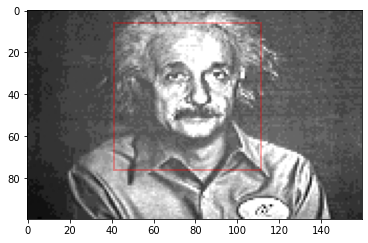

Visualize the 4° image? [Digit anything for yes/no]: 


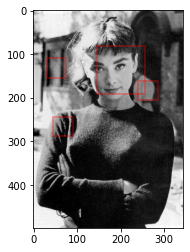

Visualize the 5° image? [Digit anything for yes/no]: 


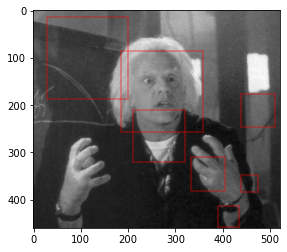

Visualize the 6° image? [Digit anything for yes/no]: 


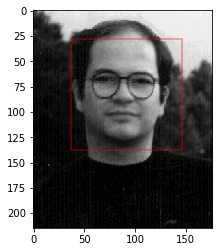

Visualize the 7° image? [Digit anything for yes/no]: 


In [ ]:
show_bboxes(test_scn_path,bboxes,image_ids)

## HARD MINING

In [ ]:
#function which defines the hard mining method, where patches with a not high enough confidence 
#are added to the augmented negative set
def hard_negative_mining(hard_neg_set,neg_set,pos_set):
    
    n_hard_neg=np.array(hard_neg_set).shape[0]
    hard_neg_subset=[]
    i=0
    
    while i < 5000:
        k=np.random.choice(n_hard_neg,1)[0]
        hard_neg_subset.append(hard_neg_set[k])
        i+=1

    neg_set=np.concatenate((neg_set, hard_neg_subset))
    #neg_set=np.concatenate((neg_set, hard_neg_set))
    print(np.array(neg_set).shape[0])

    X_train = np.array([feature.hog(im, pixels_per_cell=(6,6))
                        for im in chain(pos_set,neg_set)])
    y_train = np.zeros(X_train.shape[0])
    y_train[:np.shape(pos_set)[0]] = 1

    model = grid.best_estimator_
    model.fit(X_train, y_train)

    bboxes, confidences,image_ids,hard_neg_set=sliding_window(test_scn_path)
    
    return bboxes, confidences, image_ids, hard_neg_set, neg_set

In [ ]:
bboxes,confidences,image_ids,hard_neg_set,aug_neg_set=hard_negative_mining(hard_neg_set,aug_neg_set,aug_pos_set)

15956
DONE: run_detector


In [ ]:
np.array(hard_neg_set).shape[0]

285656

In [ ]:
#print of bounding boxes
print(bboxes.shape[0])

27


In [ ]:
# creation of dictionary to see how many bounding boxes are found for each image
counter = collections.Counter(image_ids[:,0])
counter=dict(counter)
counter

{'33190.jpg': 4,
 'aerosmith-double.jpg': 10,
 'albert.jpg': 1,
 'audrey1.jpg': 4,
 'bttf206.jpg': 7,
 'cfb.jpg': 1}

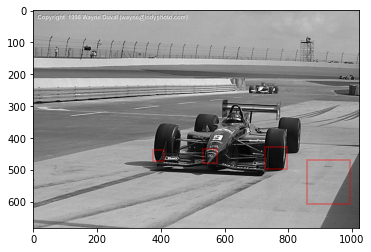

Visualize the 2° image? [Digit anything for yes/no]: 


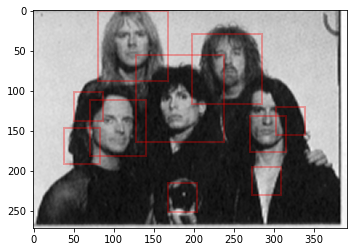

Visualize the 3° image? [Digit anything for yes/no]: 


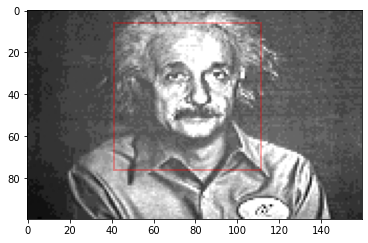

Visualize the 4° image? [Digit anything for yes/no]: 


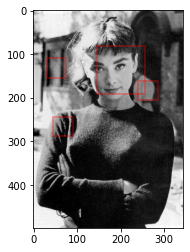

Visualize the 5° image? [Digit anything for yes/no]: 


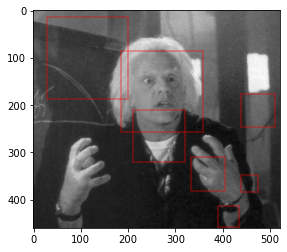

Visualize the 6° image? [Digit anything for yes/no]: 


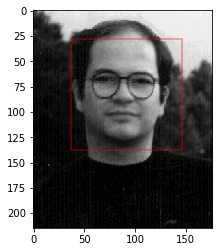

Visualize the 7° image? [Digit anything for yes/no]: 


In [ ]:
show_bboxes(test_scn_path,bboxes,image_ids)

In [ ]:
# loop of sliding window and hard mining until the negative set reaches a specified dimension
#while bboxes.shape[0]>500:
    #bboxes,confidences,image_ids,hard_neg_set,aug_neg_set=hard_negative_mining(hard_neg_set,aug_neg_set,aug_pos_set)